# 서울시 전기차 충전 데이터 이용

In [1]:
import pandas as pd
df = pd.read_csv(r'D:\charging_data\charging_data_modify.csv', encoding='cp949')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10972 entries, 0 to 10971
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   순번        10972 non-null  int64  
 1   충전소명      10972 non-null  object 
 2   충전일       10972 non-null  object 
 3   충전시작시간    10972 non-null  object 
 4   충전종료시간    10972 non-null  object 
 5   충전량(kWh)  10972 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 514.4+ KB
None


In [2]:
# 쓸모없는 열 삭제
df = df.drop('순번', axis=1)
df = df.drop('충전량(kWh)', axis=1)

# 충전소명을 기준으로 데이터 수 확인 
df['충전소명'].value_counts()

충전소명
양재솔라스테이션        2783
동작구청            1211
양천구청             960
홍제1동 공용주차장       688
어린이대공원 후문주차장     651
중랑구청             618
성동구청             537
남부초 공영주차장        476
서대문구청 주차장        449
서소문청사(지상 급속)     265
망우제2 거주자주차장      265
복정역 공영주차장        225
송월동차고지(급속)       218
송월동차고지(완속)       209
마곡중앙광장공영주차장      209
개화산역 공영주차장       183
서울시 본관청사(완속)     173
가산 공영주차장         153
남산청사             153
서소문청사(지하 급속)     138
창동역 공영주차장        111
서소문청사(후생동)        87
서울시 본관청사(급속)      79
서소문청사(완속)         62
천호역 공영주차장         62
중화1동 공영주차장         7
Name: count, dtype: int64

In [3]:
df['충전일자'] = pd.to_datetime(df['충전일'])
df['충전일자'].max() 
df['충전일자'].min()
print(df['충전일자'].max() - df['충전일자'].min()) 

117 days 00:00:00


#### 충전시간 도출

In [4]:
df['충전시작시간'] = pd.to_datetime(df['충전시작시간'])
df['충전종료시간'] = pd.to_datetime(df['충전종료시간'])

df['충전시간'] = (df['충전종료시간'] - df['충전시작시간']).dt.total_seconds() // 60
df['충전시간']


0        27.0
1        40.0
2        15.0
3        23.0
4        40.0
         ... 
10967    29.0
10968    53.0
10969    42.0
10970    53.0
10971    33.0
Name: 충전시간, Length: 10972, dtype: float64

In [5]:
df = df[df['충전시간'] >= 5]
df = df[df['충전시간'] <= 180]

df['충전소명'].value_counts()

충전소명
양재솔라스테이션        2669
동작구청            1192
양천구청             938
홍제1동 공용주차장       663
어린이대공원 후문주차장     626
중랑구청             593
성동구청             527
남부초 공영주차장        463
서대문구청 주차장        423
서소문청사(지상 급속)     256
망우제2 거주자주차장      252
송월동차고지(급속)       209
복정역 공영주차장        207
개화산역 공영주차장       175
마곡중앙광장공영주차장      148
가산 공영주차장         142
남산청사             139
서울시 본관청사(완속)     134
서소문청사(지하 급속)     132
송월동차고지(완속)       119
창동역 공영주차장        104
서울시 본관청사(급속)      70
천호역 공영주차장         57
서소문청사(완속)         51
서소문청사(후생동)        33
중화1동 공영주차장         4
Name: count, dtype: int64

In [6]:
# 충전 세션 500개 이하 삭제
filter = df['충전소명'].value_counts()

# 충전 세션이 500개 이하인 경우 삭제
to_drop = filter[filter <= 500].index

# to_drop에 들어있지 않은 loc만 추출
df = df[~df['충전소명'].isin(to_drop)]

df['충전소명'].value_counts()

충전소명
양재솔라스테이션        2669
동작구청            1192
양천구청             938
홍제1동 공용주차장       663
어린이대공원 후문주차장     626
중랑구청             593
성동구청             527
Name: count, dtype: int64

In [7]:
# 요일을 0-월 1-화 ... 6-일 로 맵핑 (datetime 객체 이용)

df['요일'] = pd.to_datetime(df['충전시작시간'])

df['요일'] = df['충전시작시간'].dt.weekday

df['요일'].value_counts()

요일
4    1192
3    1067
5    1053
2    1013
0    1002
1     995
6     886
Name: count, dtype: int64

### 아주 간단한 그래프

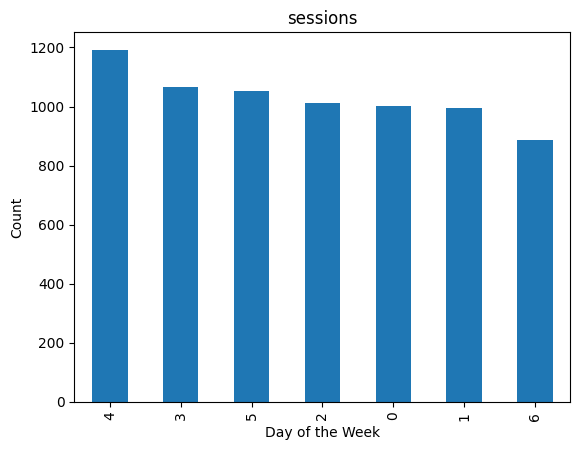

In [8]:
import matplotlib.pyplot as plt


df['요일'].value_counts().plot(kind='bar')

plt.title('sessions')
plt.xlabel('Day of the Week')
plt.ylabel('Count')

plt.show()

In [9]:
# 주말인지 아닌지 여부 데이터 추가

def is_weekend(day):
    if day in [0,1,2,3,4]: # 0: 월 6: 일
        return 0
    else:
        return 1

df['주말'] = df['요일'].apply(is_weekend)
df['주말'].value_counts()


주말
0    5269
1    1939
Name: count, dtype: int64

### 충전소 목록

양재솔라스테이션        2669
</br>
동작구청            1192
</br>
양천구청             938
</br>
홍제1동 공용주차장       663
</br>
어린이대공원 후문주차장     626
</br>
중랑구청             593
</br>
성동구청             527

In [10]:
# dfs = {name: df[df['충전소명'] == name] for name in df['충전소명'].unique()}

# for name, df in dfs.items():
#     filename = f"{name}_data_csv"
#     df.to_csv(r'D:\charging_data\\'+filename+'.csv', index=False, encoding="utf-8-sig")

새로운 데이터프레임 객체 생성

In [73]:
df_yg = pd.read_csv(r'D:\charging_data\홍제1동 공용주차장_data_csv.csv', encoding='utf-8-sig')
df_yg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   충전소명    663 non-null    object 
 1   충전일     663 non-null    object 
 2   충전시작시간  663 non-null    object 
 3   충전종료시간  663 non-null    object 
 4   충전일자    663 non-null    object 
 5   충전시간    663 non-null    float64
 6   요일      663 non-null    int64  
 7   주말      663 non-null    int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 41.6+ KB


In [74]:
df_yg_2 = pd.DataFrame()
df_yg_2['time'] = [i for i in range(144)] * 117
df_yg_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16848 entries, 0 to 16847
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   time    16848 non-null  int64
dtypes: int64(1)
memory usage: 131.8 KB


## 충전기 구분 안함.. 다시 해야 함

In [75]:
# 시작 날짜(2021년 6월 16일 기준)으로 144개씩 데이터 구분 10분 주기 -> 10T
date_range = pd.date_range('2021-06-16', periods=len(df_yg_2['time']), freq='10T') 

# 요일을 리턴
day_of_week = date_range.dayofweek

# 요일에 기반하여 5 이상인 경우 주말(1), 아닌경우 (0)
df_yg_2['weekend'] = (day_of_week >= 5).astype(int) # 1 : 주말 0: 평일
df_yg_2['dayofweek'] = day_of_week
df_yg_2['date'] = date_range.date

df_yg_2.head(150)


,time,weekend,dayofweek,date
0,0,0,2,2021-06-16
1,1,0,2,2021-06-16
2,2,0,2,2021-06-16
3,3,0,2,2021-06-16
4,4,0,2,2021-06-16
...,...,...,...,...
145,1,0,3,2021-06-17
146,2,0,3,2021-06-17
147,3,0,3,2021-06-17
148,4,0,3,2021-06-17


#### 각 충전기 별 데이터 분리 해야함

In [76]:
# 하루를 10분 단위의 144개로 나누어, 충전 시작 시간에 맞게 할당 (y 구해야 함)
def time_calculate(time):
    time_obj = pd.to_datetime(time)
    hour = time_obj.hour
    minute = time_obj.minute
    
    if hour == 0 and minute < 10:
        return 0
    elif hour == 23 and minute >= 50:
        return 143
    else:
        time_in_minutes = hour * 60 + minute
        return int(time_in_minutes / 10)


df_yg['charging_start'] = df_yg['충전시작시간'].apply(time_calculate)
df_yg['charging_end'] = df_yg['충전종료시간'].apply(time_calculate)


충전 시작과 충전 종료를 144개로 나눈 것에 맵핑 해놓았기 때문에,

if 날짜 일치:
</br>
    충전 시작 시간 ~ 충전 종료 시간 = 1 할당
</br>
else:
</br>
    continue

와 같은 식으로 가야 함.

In [77]:
df_yg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   충전소명            663 non-null    object 
 1   충전일             663 non-null    object 
 2   충전시작시간          663 non-null    object 
 3   충전종료시간          663 non-null    object 
 4   충전일자            663 non-null    object 
 5   충전시간            663 non-null    float64
 6   요일              663 non-null    int64  
 7   주말              663 non-null    int64  
 8   charging_start  663 non-null    int64  
 9   charging_end    663 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 51.9+ KB


In [78]:
import sys
import pandas as pd
import numpy as np
import datetime

sys.setrecursionlimit(10**7)

base_date = datetime.datetime.strptime("2021-06-16", '%Y-%m-%d')
interval = 143
date_dict = {}

for index, row in df_yg.iterrows():
    charging_date = datetime.datetime.strptime(row['충전일자'], '%Y-%m-%d')
    
    if charging_date in date_dict:
        charging_date_index = date_dict[charging_date]
    
    else:
        date_diff = (charging_date-base_date).days
        charging_date_index = date_diff * interval + date_diff
        date_dict[charging_date] = charging_date_index
    
    start = row['charging_start'] 
    end = row['charging_end']

    if pd.isna(charging_date_index):
        break

    df_yg_2.loc[charging_date_index + start : charging_date_index + end, 'y'] = 1
    df_yg_2.loc[charging_date_index + start-1 : charging_date_index + end-1, 'y_t_1'] = 1
df_yg_2['y'] = df_yg_2['y'].fillna(0)
df_yg_2['y_t_1'] = df_yg_2['y_t_1'].fillna(0)


In [79]:
df_yg_2 = df_yg_2[['time', 'weekend', 'dayofweek', 'y', 'y_t_1']]

In [80]:
df_yg_2.to_csv('hj_chg.csv', index=False)

1. 동작구청
2. 홍제1동 공용주차장
3. 중랑구청
4. 어린이대공원
5. 성동구청
6. 양천구청
7. 양재솔라스테이션

In [83]:
df_p = pd.read_csv(r'D:\Multistep-Electric-Vehicle-Charging-Station-Occupancy-Prediction-\korea_data\data_chg_1.csv')

for index, row in df_p.iterrows():
    

,time,weekend,dayofweek,y,y_t_1
0,0,0,2,0.0,0.0
1,1,0,2,0.0,0.0
2,2,0,2,0.0,0.0
3,3,0,2,0.0,0.0
4,4,0,2,0.0,0.0
...,...,...,...,...,...
16843,139,1,6,1.0,1.0
16844,140,1,6,1.0,1.0
16845,141,1,6,1.0,0.0
16846,142,1,6,0.0,0.0


# 143의 iteration을 기준으로 0번째일 때 충전하고 있는 경우들을 다 더하고 days로 나눔.

# 주중 / 주말 구분해야함